In [1]:
import sys
import regions
#import pyavm
import numpy as np
import PIL

from regions import Regions

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import simple_norm

import reproject 
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

from reproject import reproject_interp

from spectral_cube import SpectralCube
from spectral_cube import Projection

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils import background

import regions
import cv2

from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam

import random as rand

from astropy.table import Table

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import cutout_manager as cm
import moment_maker as mm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


# Functions

In [5]:
def get_percentile_list(data, percents=[98, 99, 99.9, 99.99]):
    #[87, 95, 99, 99.5, 99.9, 99.99]
    arr = []
    for per in percents:
        arr.append(np.nanpercentile(data, per))
    return np.array(arr)

# Filament Cutouts

In [6]:
pos_ctr = SkyCoord('17:46:20.9063719501', '-28:37:51.6942550990', unit=(u.hourangle, u.deg))
#SkyCoord('17:46:20.5098134312', '-28:37:50.9694197729', unit=(u.hourangle, u.deg))
l = 6*u.arcmin#2.0*u.arcmin
w = 4*u.arcmin#1.0*u.arcmin

In [7]:
rgb_data, rgb_wcs = cm.get_cutout_rgb(pos_ctr, l, w)

In [8]:
spitzer_data, spitzer_wcs = cm.get_cutout_glimpse_rgb(pos_ctr, w, l)

# CO Cube Cutouts

In [9]:
ls /orange/adamginsburg/cmz/nobeyama/

12CO-2.BEARS.FITS   13CO-2.S115Q.FITS   CS21.OGEO.SP.NEW.FITS
12CO-2.S115Q.FITS   C18O-2.FOREST.FITS
13CO-2.FOREST.FITS  CO3-2.ASTE.FITS


In [10]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [11]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [12]:
cube_12CO.header['RESTFRQ']

115271204000.0

In [13]:
cube_13CO.header['RESTFRQ']

110201353000.0

In [14]:
cube_C18O.header['RESTFRQ']

119782182000.0

In [15]:
mom0_12CO = mm.get_moment0(restfreq=cube_12CO.header['RESTFRQ']*u.Hz, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s, filename=fn_12CO)
mom0_13CO = mm.get_moment0(restfreq=cube_13CO.header['RESTFRQ']*u.Hz, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s, filename=fn_13CO)
mom0_C18O = mm.get_moment0(restfreq=cube_C18O.header['RESTFRQ']*u.Hz, vmin=-56*u.km/u.s, vmax=-54*u.km/u.s, filename=fn_C18O)

In [16]:
mom0_12CO_cutout = mm.get_mom0_cutout(pos_ctr, l, l, mom0_12CO)
mom0_13CO_cutout = mm.get_mom0_cutout(pos_ctr, l, l, mom0_13CO)
mom0_C18O_cutout = mm.get_mom0_cutout(pos_ctr, l, l, mom0_C18O)

# Figures

In [17]:
percents = [90, 95, 98, 99]

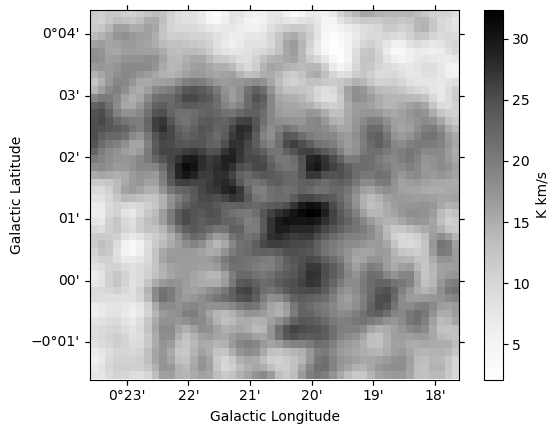

In [24]:
ax = plt.subplot(111, projection=mom0_12CO_cutout.wcs)
im = ax.imshow(mom0_12CO_cutout.data, cmap='Greys')

plt.colorbar(im, ax=ax, label='K km/s')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


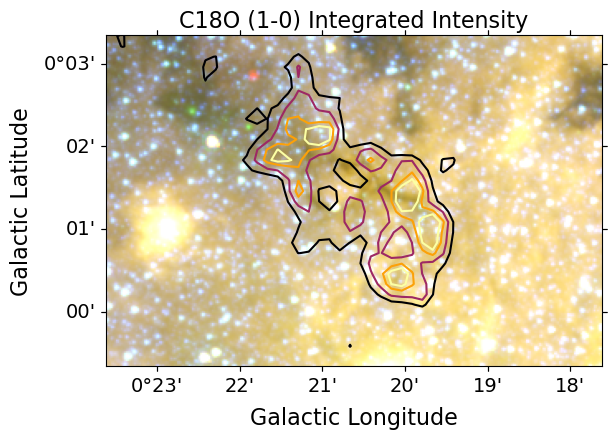

In [18]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_C18O_cutout.data, cmap='inferno', levels=get_percentile_list(mom0_C18O_cutout.data, percents=percents), transform=ax.get_transform(mom0_C18O_cutout.wcs))

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title('C18O (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)

plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/C18O_mom0_contour_filament.pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


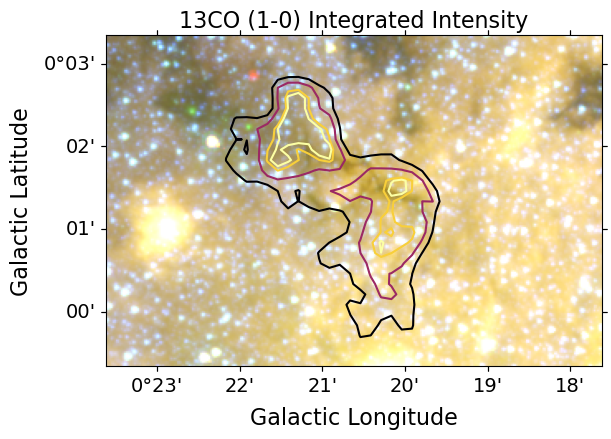

In [19]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_13CO_cutout.data, levels=get_percentile_list(mom0_13CO_cutout.data, percents=percents), 
            transform=ax.get_transform(mom0_13CO_cutout.wcs), cmap='inferno')

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title('13CO (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/13CO_mom0_contour_filament.pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


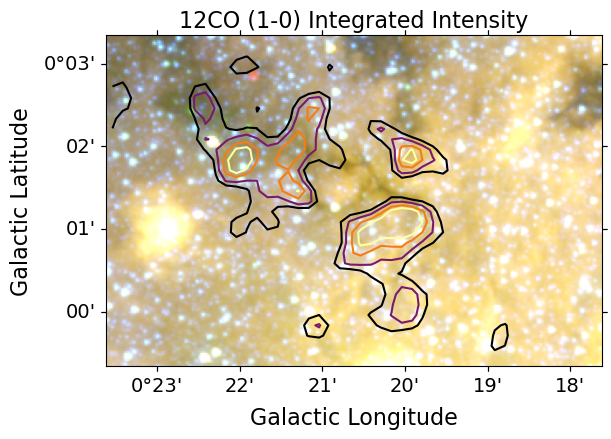

In [20]:
ax = plt.subplot(111, projection=spitzer_wcs)
ax.imshow(spitzer_data)
ax.contour(mom0_12CO_cutout.data, levels=get_percentile_list(mom0_12CO_cutout.data, percents=percents), 
            transform=ax.get_transform(mom0_12CO_cutout.wcs), cmap='inferno')

ax.set_xlabel('Galactic Longitude', fontsize=16)
ax.set_ylabel('Galactic Latitude', fontsize=16)
ax.set_title('12CO (1-0) Integrated Intensity', fontsize=16)
ax.tick_params(labelsize=14)
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/12CO_mom0_contour_filament.pdf', bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


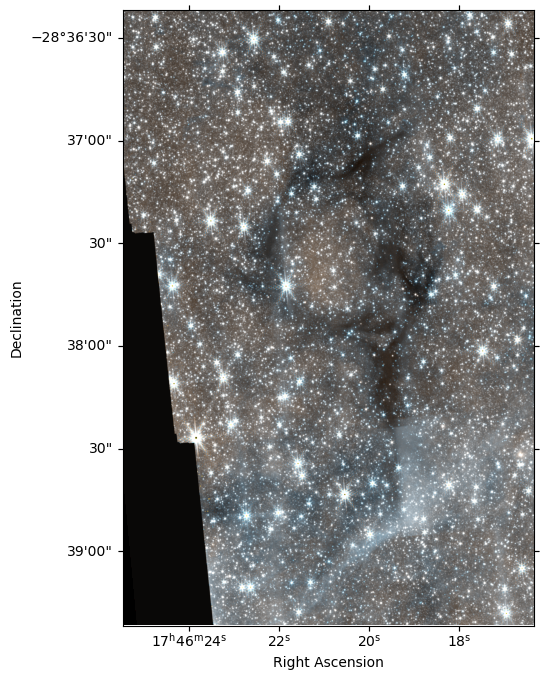

In [53]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=rgb_wcs)
ax.imshow(rgb_data, origin='lower')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

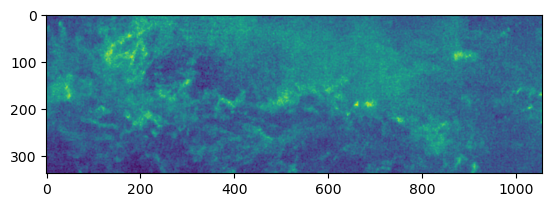

In [61]:
mom0_12CO.quicklook()

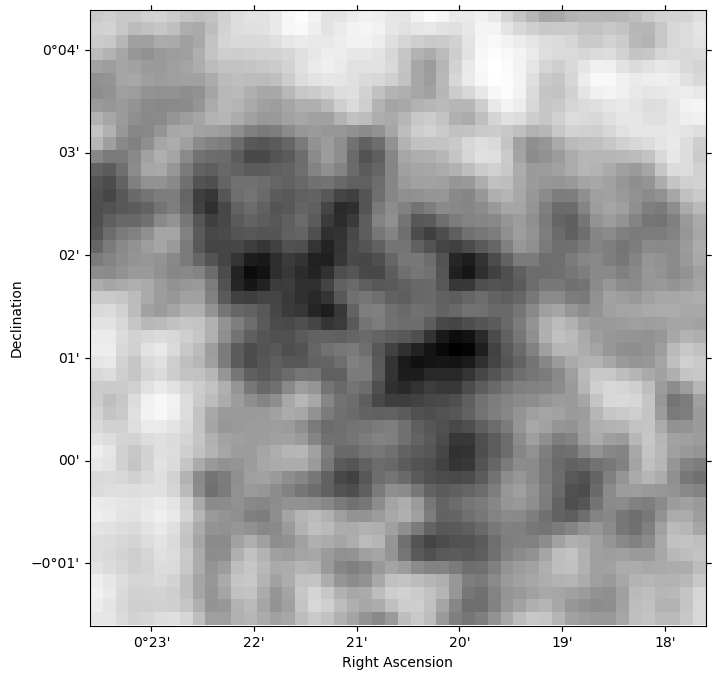

In [62]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_12CO_cutout.wcs)
ax.imshow(mom0_12CO_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

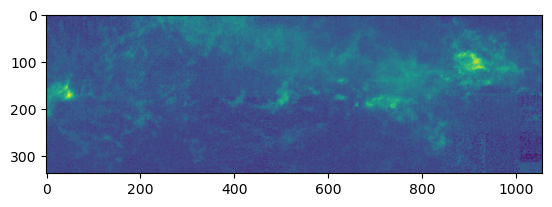

In [63]:
mom0_13CO.quicklook()

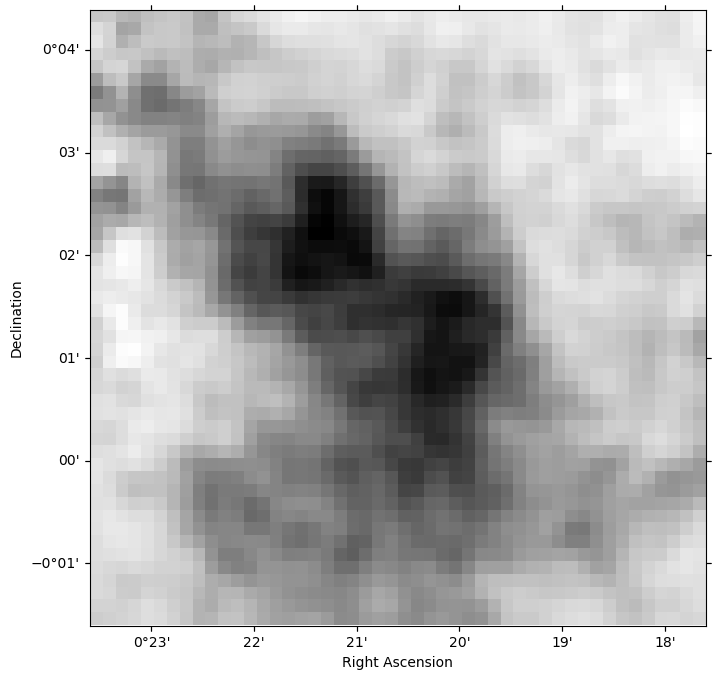

In [64]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_13CO_cutout.wcs)
ax.imshow(mom0_13CO_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

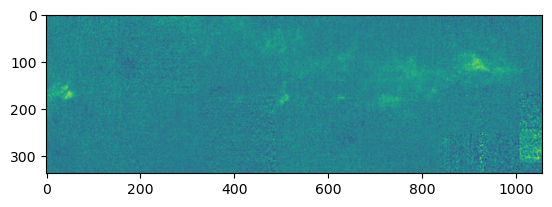

In [65]:
mom0_C18O.quicklook()

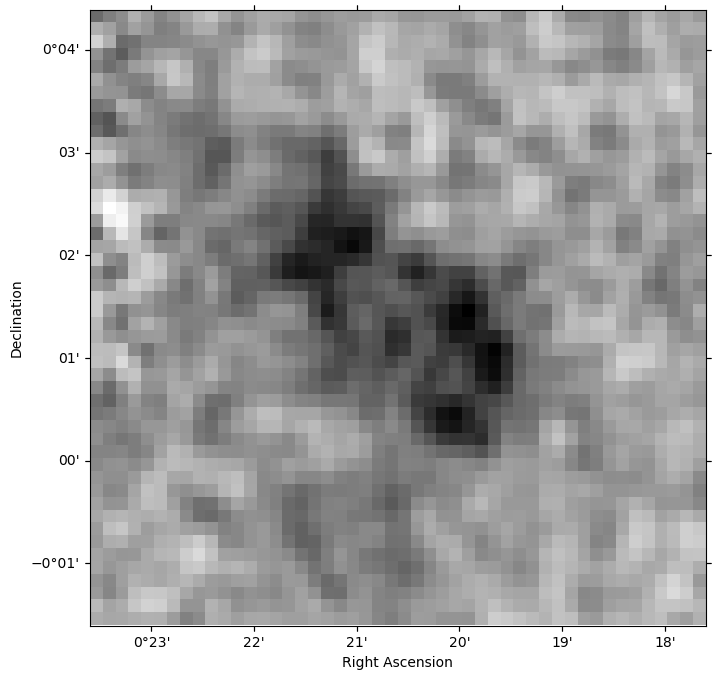

In [66]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mom0_C18O_cutout.wcs)
ax.imshow(mom0_C18O_cutout.data, origin='lower', cmap='Greys')

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')